# MediaCloud Data

MediaCloud (without downloading fulltexts, using its own collection) might be a better source because:
- It is free.
- It scales worldwide. (Nice for future research.)
- Using its collection is an alternative to the manual collection of newspapers that I made, but with the advantage that they all have (more or less) coverage by MediaCloud.
- It is not necessary to download fulltexts of all articles, but filtering and getting statistics for _all_ articles is easy via the API. This removes the bottleneck of having to scrape and store complete coverage of all newspapers.

Disadvantages:
- Some important newspapers are not covered (Zeit, FAZ, Süddeutsche, some local ones).
- The API may be slower than local querying.

In [1]:
from os import environ

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv

from src.util import get

load_dotenv()


def get_german_media(last_media_id=0):
    num_rows = 100
    response = get(
        "https://api.mediacloud.org/api/v2/media/list/",
        params={
            "last_media_id": last_media_id,
            "rows": num_rows,
            # tag 38379816 is 'Media is largely about Germany - State & Local'
            "tags_id": 38379816,
            "key": environ["MEDIACLOUD_API_KEY"],
        },
        headers={"Accept": "application/json"},
    )
    result = response.json()
    if len(result) == num_rows:
        result += get_german_media(result[-1]["media_id"])
    return result


media = get_german_media()
# tag 9361429 is 'Media sources for which the primary language is German'
media = [
    m for m in media if any([t["tags_id"] == 9361429 for t in m["media_source_tags"]])
]
media = [m for m in media if m["num_stories_90"] > 10]
media = sorted(media, key=lambda m: m["num_stories_90"], reverse=True)
len(media)

134

In [2]:
import json

with open(project_root / "data" / "news" / "german_newspapers.json", "w") as f:
    json.dump([{"name": m["name"], "media_id": m["media_id"]} for m in media], f)

In [3]:
media_names = {m["media_id"]: m["name"] for m in media}

In [4]:
# get media health info
response = get(
    "https://api.mediacloud.org/api/v2/mediahealth/list/",
    params={
        "media_id": [m["media_id"] for m in media],
        "key": environ["MEDIACLOUD_API_KEY"],
    },
    headers={"Accept": "application/json"},
)
media_health = response.json()

"Expected stories" is used as a technical term here with the meaning: _Average number of stories collected for each of the 20 days with the highest number of stories._ A coverage gap exists if _fewer than 25% of expected_stories or expected_sentences were collected_. [Mediacloud API Docs](https://github.com/mediacloud/backend/blob/master/doc/api_2_0_spec/api_2_0_spec.md#apiv2mediahealthlist)

Text(0, 0.5, 'Expected stories per day*')

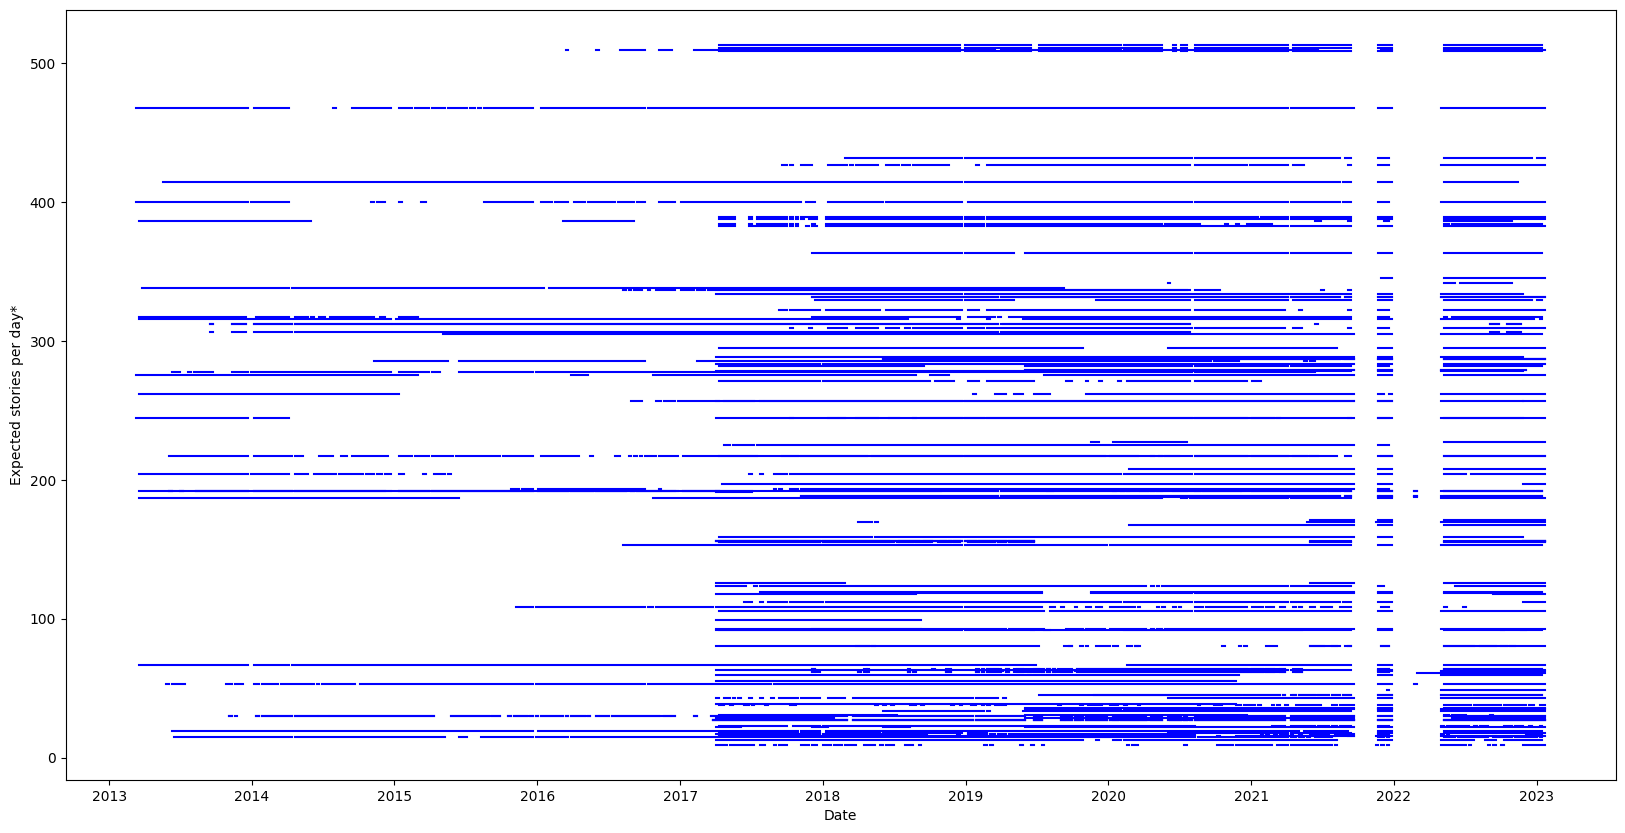

In [5]:
from datetime import datetime, timedelta

plt.figure(figsize=(20, 10))
for medium in media_health:
    start_date = datetime.strptime(medium["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(medium["end_date"], "%Y-%m-%d")
    if medium["coverage_gaps_list"] is not None:
        gap_weeks = [
            datetime.strptime(gap["stat_week"], "%Y-%m-%d")
            for gap in medium["coverage_gaps_list"]
        ]
        for gap_week in gap_weeks:
            plt.plot(
                [start_date, gap_week],
                [medium["expected_stories"], medium["expected_stories"]],
                "b-",
            )
            start_date = gap_week + timedelta(days=7)
    plt.plot(
        [start_date, end_date],
        [medium["expected_stories"], medium["expected_stories"]],
        "b-",
    )
plt.xlabel("Date")
plt.ylabel("Expected stories per day*")

In [6]:
media[0]["name"]

'hna'

In [7]:
from src.data.news.sources.mediacloud import get_article_counts


def get_article_counts_(media_id, start_date, end_date):
    df = pd.DataFrame(get_article_counts(media_id, start_date, end_date))
    df["date"] = pd.to_datetime(df["date"])
    df = df[df["date"] < datetime.now()]
    df = df[df["count"] > 1]
    df["media_id"] = medium["media_id"]
    df["media_name"] = medium["name"]
    return df

In [8]:
from src.data.protests.config import search_string


def get_protest_counts(media_id, query=search_string[1:]):
    response = get(
        "https://api.mediacloud.org/api/v2/stories_public/count/",
        params={
            "q": query,
            "fq": f"media_id:{media_id}",
            "split": True,
            "split_period": "day",
            "key": environ["MEDIACLOUD_API_KEY"],
        },
        headers={"Accept": "application/json"},
    )
    result = response.json()
    df = pd.DataFrame(result["counts"])
    df["date"] = pd.to_datetime(df["date"])
    df = df[(df["date"].dt.year >= 2013) & (df["date"] < datetime.now())]
    df["media_id"] = media_id
    df["name"] = media_names[media_id]
    return df

  0%|          | 0/134 [00:00<?, ?it/s]

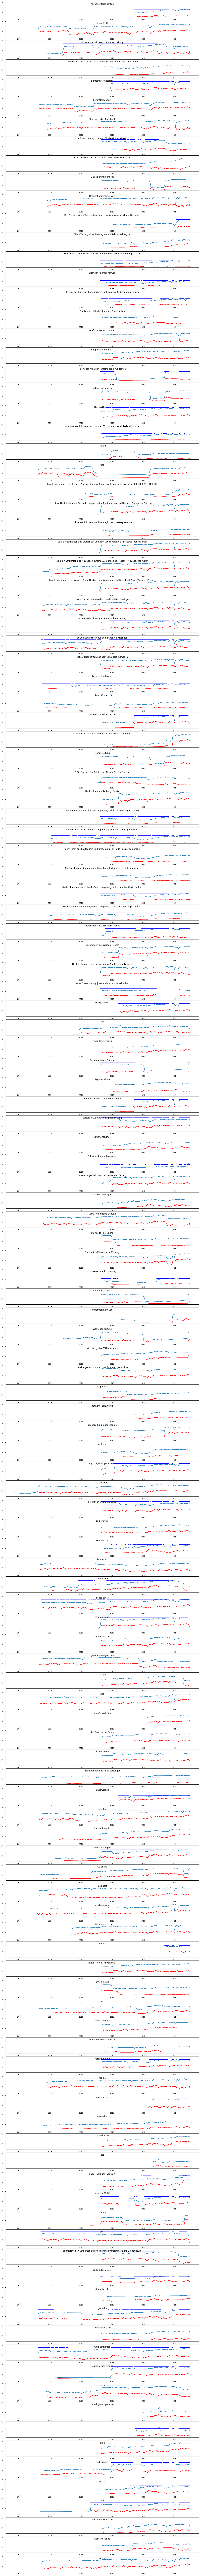

In [9]:
from tqdm.notebook import tqdm

media_ = media

fig, axs = plt.subplots(
    len(media_), figsize=(20, 2 * len(media_)), sharex=True, sharey=True
)
media_ = sorted(media_, key=lambda m: m["name"])
dfs = []
for ax, medium in tqdm(list(zip(axs, media_))):
    # plot count data
    df = get_article_counts_(medium["media_id"])
    dfs.append(df)
    df = df.set_index("date")
    df["count"] = df["count"].rolling(30).mean()
    ax.set_yscale("log")
    ax.xaxis.set_tick_params(labelbottom=True)
    ax.set_title(medium["name"], y=0.75)
    ax.plot(df["count"])
    # plot health data
    medium_health = [m for m in media_health if m["media_id"] == medium["media_id"]][0]
    start_date = datetime.strptime(medium_health["start_date"], "%Y-%m-%d")
    end_date = datetime.strptime(medium_health["end_date"], "%Y-%m-%d")
    if medium_health["coverage_gaps_list"] is not None:
        gap_weeks = [
            datetime.strptime(gap["stat_week"], "%Y-%m-%d")
            for gap in medium_health["coverage_gaps_list"]
        ]
        for gap_week in gap_weeks:
            ax.plot(
                [start_date, gap_week],
                [medium_health["expected_stories"], medium_health["expected_stories"]],
                "b-",
            )
            start_date = gap_week + timedelta(days=7)
    ax.plot(
        [start_date, end_date],
        [medium_health["expected_stories"], medium_health["expected_stories"]],
        "b-",
    )
    # plot protest data
    protest_df = get_protest_counts(medium["media_id"])
    protest_df = protest_df.set_index("date")
    protest_df["count"] = protest_df["count"].rolling(30).mean()
    ax.plot(protest_df["count"], "r-")
plt.show()
count_df = pd.concat(dfs)
count_df = count_df.reset_index()
count_df.to_csv(project_root / "data" / "news" / "german_media_counts.csv", index=False)

In [10]:
[a for a in media_names.items() if "noz" in a[1]]

[(70220, 'noz.de')]

In [11]:
count_df = get_article_counts(70220)
count_df["count"].sum()

510841

In [12]:
protest_count_df = get_protest_counts(70220)
protest_count_df["count"].sum()

27762

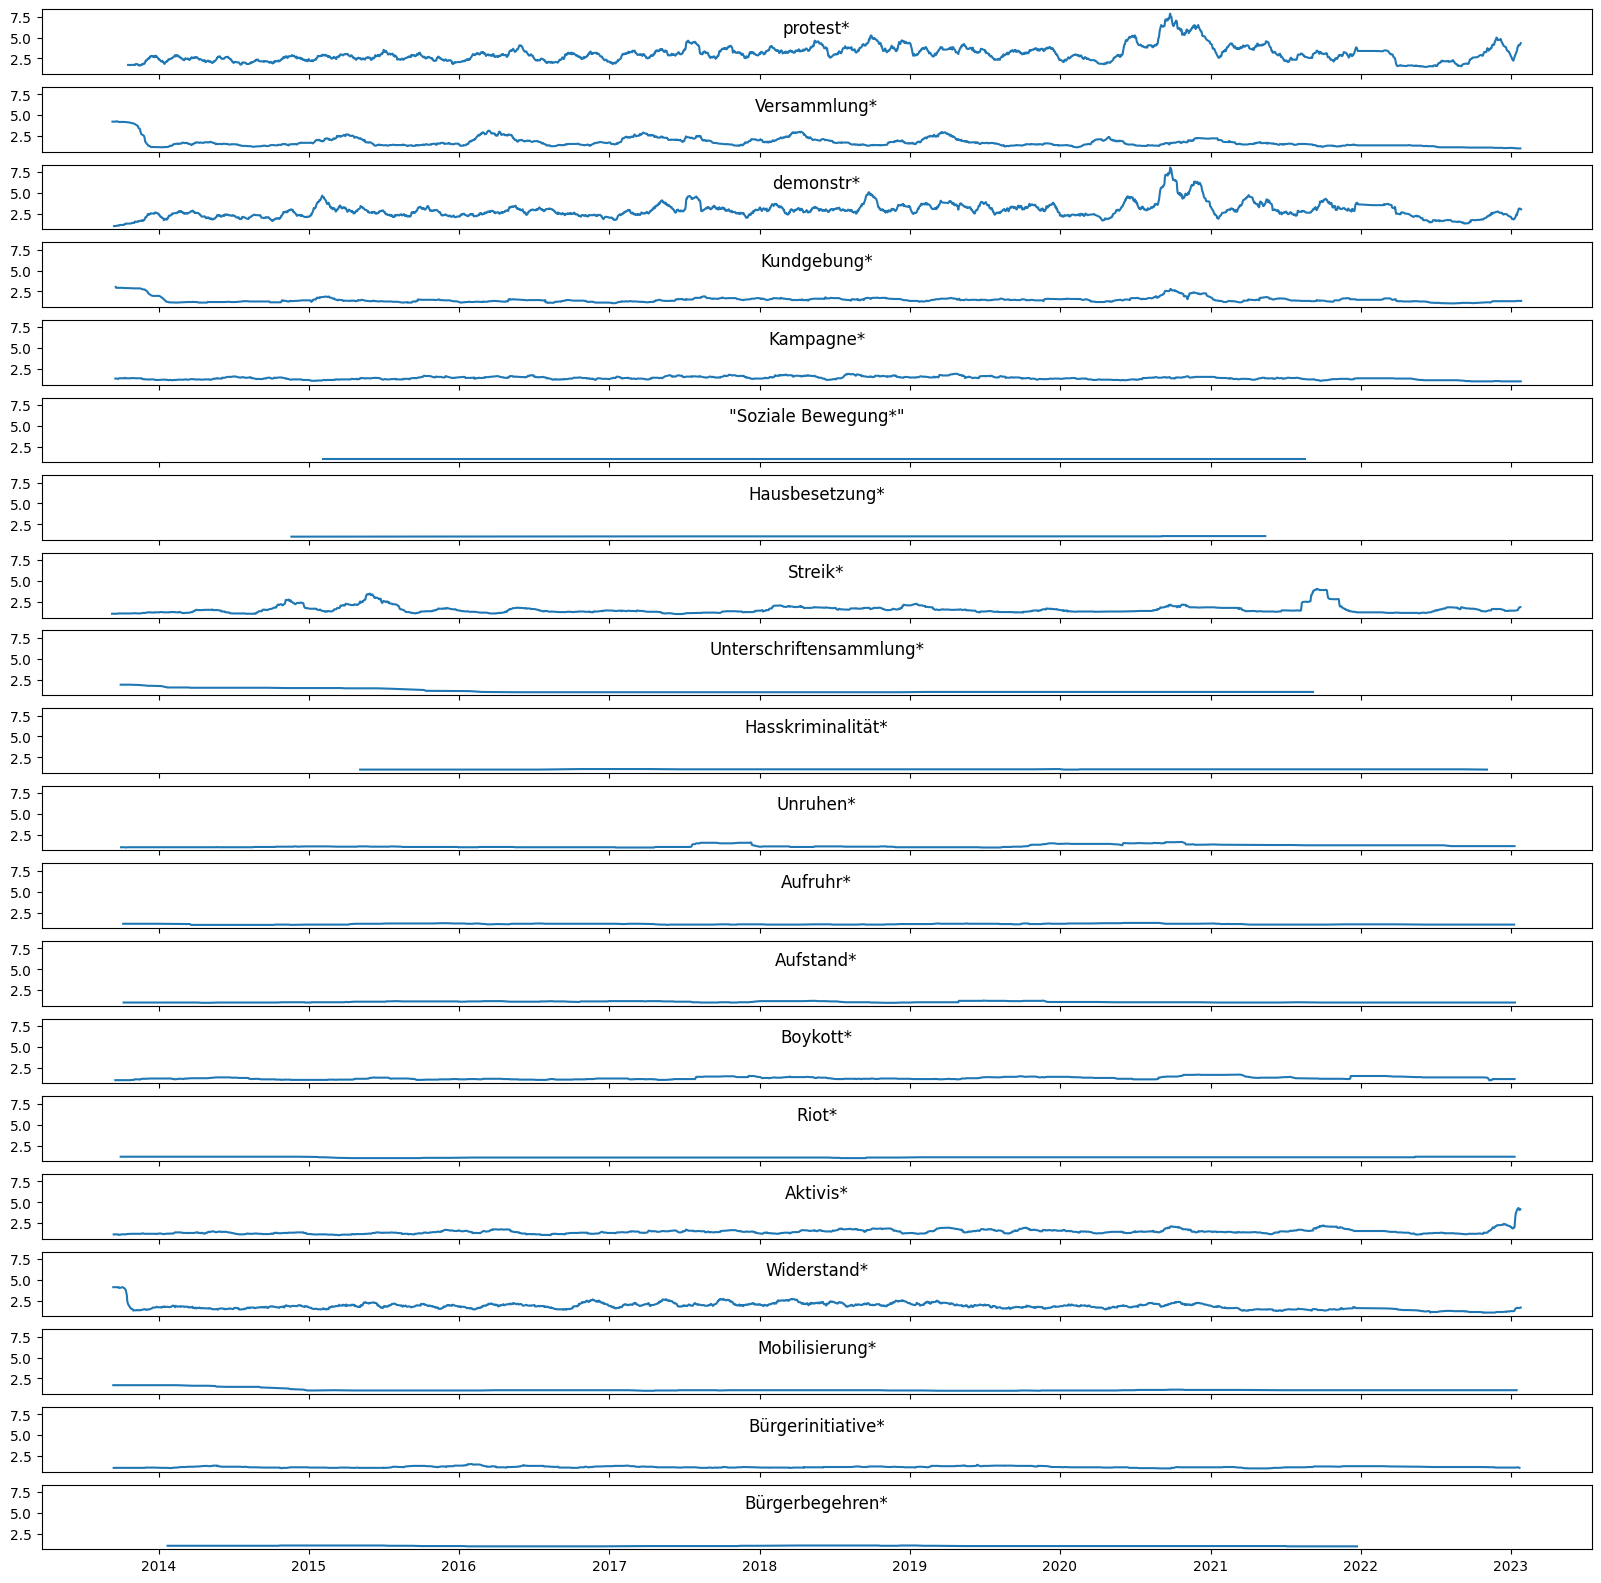

In [13]:
query_parts = search_string[1:].split(" OR ")
part_dfs = []
for part in query_parts:
    part_df = get_protest_counts(70220, query=part)
    part_df["query"] = part
    part_dfs.append(part_df)
part_df = pd.concat(part_dfs)
part_df = part_df.reset_index()
part_df["count"] = part_df["count"].rolling(30).mean()

# plot counts for each part
fig, axs = plt.subplots(
    len(query_parts), figsize=(20, len(query_parts)), sharex=True, sharey=True
)
for ax, part in zip(axs, query_parts):
    df = part_df[part_df["query"] == part]
    ax.plot(df["date"], df["count"])
    ax.set_title(part, y=0.5)
plt.show()

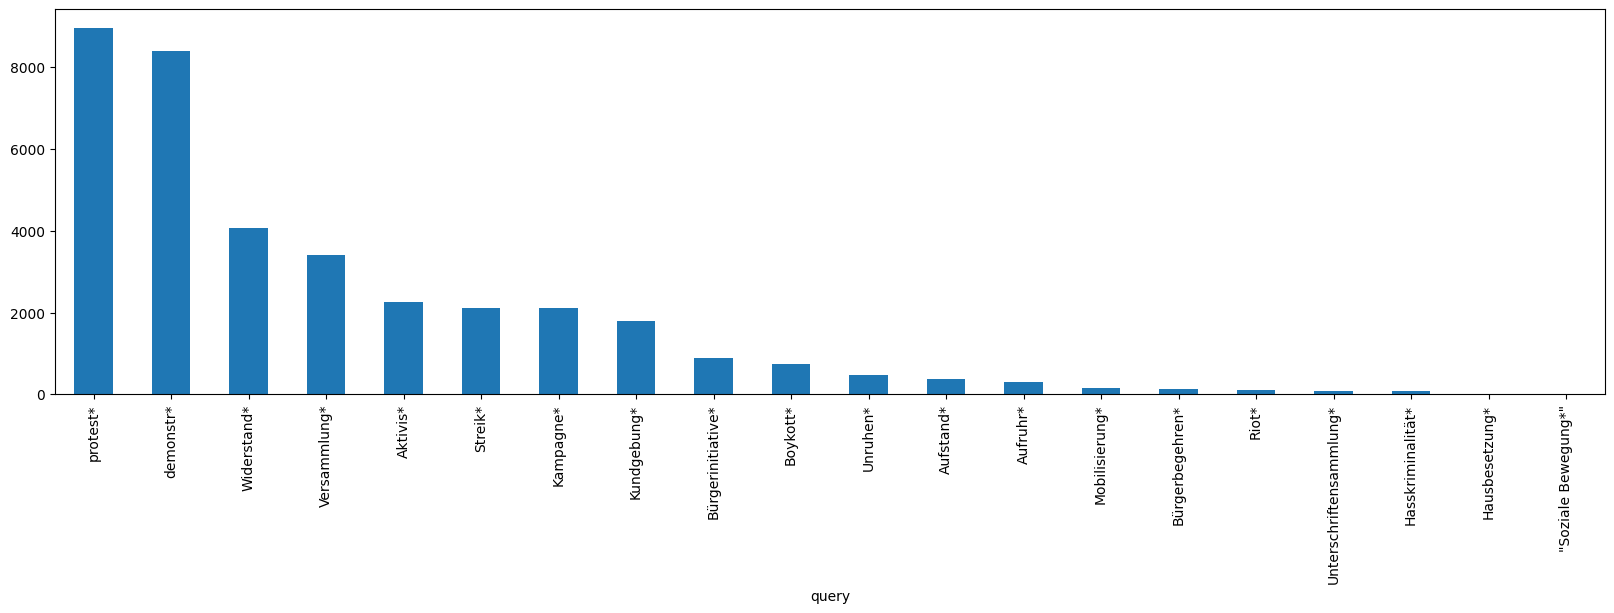

In [14]:
# bar plot to compare overall counts for the different parts of the query
# sorted by most common
fig, ax = plt.subplots(figsize=(20, 5))
part_df.groupby("query")["count"].sum().sort_values(ascending=False).plot.bar(ax=ax)
plt.show()

In [15]:
from time import time

start = time()
intervals = []